In [1]:
%%time
dataset_name = "W20_comb"
df_list = "BES_Panel"

%matplotlib inline
%run BES_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

Wall time: 55.2 s


In [2]:
search(BES_Panel,"zero|selfOccStatus|al_scale|lr_scale")

zeroHourContractW6             28721
zeroSum7W14                     7939
zeroSum11W14                    7939
zeroSum5W14                     7939
zeroSum9W14                     7939
zeroSum1W14                     7939
zeroSum4W14                     7939
selfOccStatusW16               19738
selfOccStatusLastW16           15935
selfOccStatusW17                4541
selfOccStatusLastW17            3809
selfOccStatusW18                1165
selfOccStatusLastW18             688
selfOccStatusW19               15534
selfOccStatusLastW19           15421
selfOccStatusW20               15978
selfOccStatusLastW20           13855
lr_scaleW1_W5                  38503
al_scaleW1_W5                  37890
lr_scaleW6                     27819
al_scaleW6                     27288
lr_scaleW7_W9                  36472
al_scaleW7_W9                  35873
lr_scaleW10_W12                30352
al_scaleW10_W12                30088
lr_scaleW13                    28065
al_scaleW13                    27253
l

In [3]:
# selfOccStatusW1W2W3W4W5        15913
# selfOccStatusW6_W12            30010
# zeroHourContractW6             28721

# lr_scaleW6                     27819
# al_scaleW6                     27288

In [4]:
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')

In [5]:
BES_Panel["zeroHourContractW6"].value_counts()

Should definitely be illegal    9769
Should probably be illegal      7475
Should definitely be legal      5321
Should probably be legal        4525
Don't know                      1631
Name: zeroHourContractW6, dtype: int64

In [6]:
zeroHour = BES_Panel["zeroHourContractW6"].cat.reorder_categories(['Should definitely be illegal', 'Should probably be illegal', "Don't know",
       'Should probably be legal', 'Should definitely be legal']).cat.codes.replace(-1,np.nan)

In [7]:
zeroHour.value_counts()

0.0    9769
1.0    7475
4.0    5321
3.0    4525
2.0    1631
dtype: int64

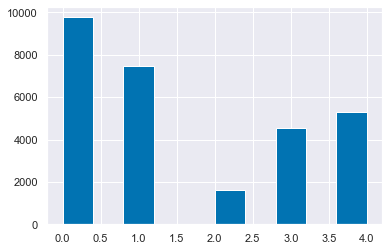

In [8]:
zeroHour.hist()

In [9]:
BES_Panel[["selfOccStatusW1W2W3W4W5","selfOccStatusW6_W12"]][zeroHour.notnull()].notnull().sum(axis=1).value_counts()

0    12842
2     9771
1     6108
dtype: int64

In [10]:
BES_Panel[["selfOccStatusW1W2W3W4W5","selfOccStatusW6_W12"]]

,selfOccStatusW1W2W3W4W5,selfOccStatusW6_W12
id,,
1,NaN,NaN
2,Self-employed/independent contractor,NaN
3,NaN,NaN
4,An employee,NaN
5,Self-employed/independent contractor,NaN
...,...,...
102854,NaN,NaN
102855,NaN,NaN
102856,NaN,NaN


In [11]:
BES_Panel[search(BES_Panel,"selfOccStatusW").index].stack().value_counts()

An employee                             92320
Self-employed/independent contractor    15164
Don't know                               1056
dtype: int64

In [12]:
BES_Panel[search(BES_Panel,"selfOccStatusW").index].apply(lambda x: len(x.unique()),axis=1 ).value_counts()

2    53795
1    45453
3     2136
4       29
dtype: int64

In [13]:
num_diff_cats = BES_Panel[search(BES_Panel,"selfOccStatusW").index].apply(lambda x: len(x.dropna().unique()),axis=1 )
#

In [14]:
BES_Panel[search(BES_Panel,"selfOccStatusW").index][0:100].loc[9].unique()

[NaN, 'Self-employed/independent contractor', 'An employee']
Categories (2, object): ['Self-employed/independent contractor' < 'An employee']

In [15]:
num_diff_cats.value_counts()

1    53795
0    45453
2     2136
3       29
dtype: int64

In [16]:
2/55

## change of status ~3-4%

0.03636363636363636

In [17]:
def amalgamate_waves(df, pattern, forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True):
    # euref_imm = amalgamate_waves(BES_reduced_with_na,"euRefVoteW",forward_fill=False)
    # assumes simple wave structure, give a pattern that works!
    if match:
        df_cols_dict = {int(re.search("W(\d+)", x).groups()[0]):x for x in df.columns if re.match(pattern, x)}
    else:
        df_cols_dict = {int(re.search("W(\d+)", x).groups()[0]):x for x in df.columns if re.search(pattern, x)}
    # sort columns
    if specify_wave_order is not None:
        df_cols = [df_cols_dict[x] for x in specify_wave_order]
    else:
        df_cols = [df_cols_dict[x] for x in sorted(df_cols_dict.keys())]
    
    # forward fill and and pick last column - or backward fill and pick first column
    if len(df_cols)<=1:
        raise Exception("Can't amalgamate less than two variables!")
    if forward_fill:
        pick_col = -1
        method = "ffill"        
    else:
        pick_col = 0
        method = "bfill"
    latest_series = df[df_cols]\
        .replace(low_priority_values,[np.nan]*len(low_priority_values))\
        .fillna(method=method,axis=1)[df_cols[pick_col]]
    # stop values in low_priority from cascading, overwrite where possible, otherwise reinsert where there are only nans 
    categories = df[df_cols[0]].cat.categories
    if low_priority_values:
        high_priority_values = [x for x in categories if x not in low_priority_values]
        low_priority_series = df[df_cols]\
                .replace(high_priority_values,[np.nan]*len(high_priority_values))\
                .fillna(method=method,axis=1)[df_cols[pick_col]]
        # apply doesn't trigger on NaN values!
        low_priority_mask = low_priority_series.apply(lambda x: x in low_priority_values).astype('bool').fillna(False) & latest_series.isnull()
        latest_series.loc[low_priority_mask] = low_priority_series.loc[low_priority_mask]
    # if it's a category, retain category type/options/order
    if df[df_cols[0]].dtype.name == "category":
        latest_series = latest_series.astype(
                    pd.api.types.CategoricalDtype(categories) )
    # update name
    # re.match("(.*?)W\d+","climateChangeW11").groups()[0]
    print("Amalgamating variables: ")
    print(df_cols_dict,df_cols)
    name_stub = re.match("(.*?)W\d+",  list(df_cols_dict.values())[0]).groups()[0]
    latest_series.name = name_stub+"W"+"&".join([str(x) for x in sorted(df_cols_dict.keys())])
    
    return latest_series

In [18]:
# (df, pattern, forward_fill=True, specify_wave_order = None, low_priority_values = [], match=True)
selfOccStatus = amalgamate_waves(BES_Panel,"selfOccStatusW",forward_fill=False)

Amalgamating variables: 
{16: 'selfOccStatusW16', 17: 'selfOccStatusW17', 18: 'selfOccStatusW18', 19: 'selfOccStatusW19', 20: 'selfOccStatusW20', 1: 'selfOccStatusW1W2W3W4W5', 6: 'selfOccStatusW6_W12', 14: 'selfOccStatusW14W15'} ['selfOccStatusW1W2W3W4W5', 'selfOccStatusW6_W12', 'selfOccStatusW14W15', 'selfOccStatusW16', 'selfOccStatusW17', 'selfOccStatusW18', 'selfOccStatusW19', 'selfOccStatusW20']


In [19]:
# print("responsive?")

In [20]:
selfOccStatus.isnull().sum()

45453

In [21]:
selfOccStatus.value_counts()

An employee                             47273
Self-employed/independent contractor     7916
Don't know                                771
Name: selfOccStatusW1&6&14&16&17&18&19&20, dtype: int64

In [22]:
## drop any remaining Don't knows
selfOccStatus = selfOccStatus.replace("Don't know",np.nan)
selfOccStatus.value_counts()

An employee                             47273
Self-employed/independent contractor     7916
Name: selfOccStatusW1&6&14&16&17&18&19&20, dtype: int64

In [23]:
al_scale = amalgamate_waves(BES_Panel,"al_scale",forward_fill=False)

Amalgamating variables: 
{1: 'al_scaleW1_W5', 6: 'al_scaleW6', 7: 'al_scaleW7_W9', 10: 'al_scaleW10_W12', 13: 'al_scaleW13', 14: 'al_scaleW14W15', 16: 'al_scaleW16', 17: 'al_scaleW17', 20: 'al_scaleW20'} ['al_scaleW1_W5', 'al_scaleW6', 'al_scaleW7_W9', 'al_scaleW10_W12', 'al_scaleW13', 'al_scaleW14W15', 'al_scaleW16', 'al_scaleW17', 'al_scaleW20']


In [24]:
al_scale.value_counts(dropna=False)

7.5              9821
7.0              8592
6.5              8265
NaN              7136
8.0              7071
6.0              6928
5.0              6517
5.5              6221
8.5              5732
9.0              5056
4.5              4671
4.0              4104
9.5              3587
3.5              3484
Authoritarian    3443
3.0              3079
2.5              2484
2.0              1962
1.5              1294
1.0               951
0.5               553
Libertarian       462
Name: al_scaleW1&6&7&10&13&14&16&17&20, dtype: int64

In [25]:
al_scale = al_scale.cat.codes.replace(-1,np.nan)

In [26]:
df = pd.concat([zeroHour,selfOccStatus,al_scale],axis=1)
df.columns = ["zeroHour","selfOccStatus","al_scale"]

In [27]:
df

,zeroHour,selfOccStatus,al_scale
1,0.0,NaN,16.0
2,3.0,Self-employed/independent contractor,12.0
3,3.0,NaN,14.0
4,NaN,An employee,16.0
5,NaN,Self-employed/independent contractor,12.0
...,...,...,...
102854,NaN,An employee,8.0
102855,NaN,NaN,11.0
102856,NaN,An employee,11.0
102857,NaN,An employee,19.0


In [28]:
df.isnull().sum()

zeroHour         72692
selfOccStatus    46224
al_scale          7136
dtype: int64

In [29]:
df[df["zeroHour"].notnull()].isnull().sum()

zeroHour             0
selfOccStatus    12302
al_scale           470
dtype: int64

In [30]:
mask = df.notnull().all(axis=1)

In [31]:
df["al_scale"].value_counts()
al_mask = df["al_scale"].apply(lambda x: x in [0.0,10.0,20.0])

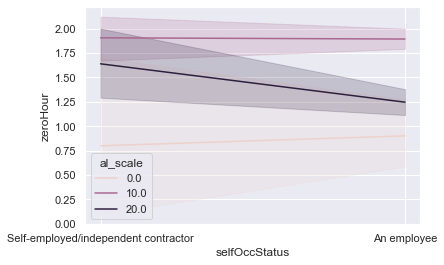

In [32]:
sns.lineplot(data = df[mask&al_mask],x="selfOccStatus",y="zeroHour",hue="al_scale")

In [33]:
# We deviate because no controls!
# Also we haven't weighted!


# Modeling Approach
# We use a simple linear regression model specification with the relevant outcome measure y regressed
# on authoritarianism, the relevant demographic and interaction between the demographic and
# authoritarianism. Where the demographic variable is categorical we include main effects and
# interactions for each category other than the baseline. For each outcome variable we run two models,
# the first as described above, and the second with additional controls for age and education level (BESIP:
# No qualifications, Below GCSE, GCSE, A-level, Undergraduate degree, Postgraduate degree. ANES:
# High school or less, Some college, Bachelors degree, Postgraduate degree).
# 1. 𝑦 = 𝛽0 + 𝛽1𝑎𝑢𝑡ℎ + 𝛽2𝑑𝑒𝑚𝑜𝑔𝑟𝑎𝑝ℎ𝑖𝑐 + 𝛽3𝑎𝑢𝑡ℎ ∗ 𝑑𝑒𝑚𝑜𝑔𝑟𝑎𝑝ℎ𝑖𝑐
# 2. 𝑦 = 𝛽0 + 𝛽1𝑎𝑢𝑡ℎ + 𝛽2𝑑𝑒𝑚𝑜𝑔𝑟𝑎𝑝ℎ𝑖𝑐 + 𝛽3𝑎𝑢𝑡ℎ ∗ 𝑑𝑒𝑚𝑜𝑔𝑟𝑎𝑝ℎ𝑖𝑐 + 𝛽4𝐴𝑔𝑒 +
# 𝛽5𝑖𝐸𝑑𝑢𝑐𝑎𝑡𝑖𝑜𝑛�

In [34]:
search(BES_Panel,"gayMarriage|p_sexualityW10|houseBuildW12|p_housingW12|")

# blackEqualityW16       37959,blackEqualityW17       34366
# p_ethnicityW16         37744,p_ethnicityW17         34014

# tuitionFeesTooFarW13    31136
# anyUniW13               31136

# welfarePreferenceW11      30956
# mainSourceIncomeW11       29461

# leftRightW10    30237
# populism1W10    30237
# populism2W10    30237
# populism4W10    30237
# populism5W10    30237
# populism6W10    30237

# overseasAidW17         34366
# subjClassW17           34366


# objective class
# economic left-right

wave1        100936
wave2        100936
wave3        100936
wave4        100936
wave5        100936
              ...  
oslauaW17     34366
oslauaW18     37824
oslauaW19     32177
oslauaW20     31468
oslauaW16     37958
Length: 8535, dtype: int64

In [35]:
search(BES_Panel,"overseasAid|subjClass|lr\d")

lr1W6                  30258
lr2W6                  30258
lr3W6                  30258
lr4W6                  30258
lr5W6                  30258
overseasAidW10         30237
overseasAidW11         30956
overseasAidW12          8984
lr1W13                 31136
lr2W13                 31136
lr3W13                 31136
lr4W13                 31136
lr5W13                 31136
overseasAidW14         31063
forcedSubjClassW14      7939
subjClassW15            5109
lr1W16                 37959
lr2W16                 37959
lr3W16                 37959
lr4W16                 37959
lr5W16                 37959
subjClassW16           13775
overseasAidW17         34366
subjClassW17           34366
lr1W17                 34366
lr2W17                 34366
lr3W17                 34366
lr4W17                 34366
lr5W17                 34366
subjClassW19           32177
subjClassSqueezeW19    11125
lr1W20                 31468
lr2W20                 31468
lr3W20                 31468
lr4W20        

In [36]:
BES_Panel["p_educationW13"].value_counts()

University or CNAA first degree (e.g. BA, B.Sc, B.Ed)    6506
CSE grade 1, GCE O level, GCSE, School Certificate       4042
GCE A level or Higher Certificate                        4035
Other technical, professional or higher qualification    3597
University or CNAA higher degree (e.g. M.Sc, Ph.D)       2784
No formal qualifications                                 2100
City & Guilds certificate                                1285
University diploma                                       1175
City & Guilds certificate - advanced                      729
Teaching qualification (not degree)                       703
CSE grades 2-5                                            620
Scottish Higher Certificate                               607
Prefer not to say                                         593
Clerical and commercial                                   542
Nursing qualification (e.g. SEN, SRN, SCM, RGN)           481
Recognised trade apprenticeship completed                 423
Don't kn

In [37]:
# interesting

# fourDayWeek Introducing a four day working week W17
# abolishPrivateSchool Getting rid of private education W17
# votesAt16 Lowerin

In [38]:
# Thomas Prosser:
# But I'm interested in things like the political views of sociocultural professionals (particularly on the cultural dimension)
# and the size of sociocultural sectors.

In [39]:
## Thought - do vocational categories form specific 

In [40]:
search(BES_Panel,"ns_sec")

ns_secW16W17W18              38586
ns_sec_analyticW16W17W18     38586
ns_secW19                    26107
ns_sec_analyticW19           26107
ns_secW20                    25655
ns_sec_analyticW20           25655
ns_secW1W2W3W4W5             26183
ns_sec_analyticW1W2W3W4W5    26391
ns_secW6W7W8W9               40099
ns_sec_analyticW6W7W8W9      40099
dtype: int64

In [41]:
## Obvious value confounds

# Age

# Dumb control, just look at one decade at a time

In [42]:
BES_Panel["ns_secW16W17W18"].value_counts()

L4.1 Traditional employees                                                     6572
L7.1 Intermediate clerical and administrative occupations                      5762
L3.1 Traditional employees                                                     2287
L3.2 New employees                                                             2199
L9.1 Own account workers (non-professional)                                    2120
L7.2 Intermediate sales and service occupations                                1872
Lower managerial and administrative occupations                                1872
Higher supervisory occupations                                                 1835
Lower supervisory occupations                                                  1631
L12.2 Semi-routine service occupations                                         1582
L12.1 Semi-routine sales occupations                                           1420
Higher managerial and administrative occupations                            

In [43]:
BES_Panel["ns_sec_analyticW16W17W18"].value_counts()

Lower professional and managerial and higher supervisory    12234
Intermediate occupations                                     8450
Higher professional occupations                              5110
Semi-routine occupations                                     3954
Employers in small organisations and own account workers     2778
Lower supervisory and technical occupations                  2511
Routine occupations                                          2308
Employers in large organisations and higher managerial       1241
Name: ns_sec_analyticW16W17W18, dtype: int64

In [44]:
ns_sec_analytic = amalgamate_waves(BES_Panel,"ns_sec_analytic")

Amalgamating variables: 
{16: 'ns_sec_analyticW16W17W18', 19: 'ns_sec_analyticW19', 20: 'ns_sec_analyticW20', 1: 'ns_sec_analyticW1W2W3W4W5', 6: 'ns_sec_analyticW6W7W8W9'} ['ns_sec_analyticW1W2W3W4W5', 'ns_sec_analyticW6W7W8W9', 'ns_sec_analyticW16W17W18', 'ns_sec_analyticW19', 'ns_sec_analyticW20']


In [45]:
ns_sec = amalgamate_waves(BES_Panel,"ns_secW")

Amalgamating variables: 
{16: 'ns_secW16W17W18', 19: 'ns_secW19', 20: 'ns_secW20', 1: 'ns_secW1W2W3W4W5', 6: 'ns_secW6W7W8W9'} ['ns_secW1W2W3W4W5', 'ns_secW6W7W8W9', 'ns_secW16W17W18', 'ns_secW19', 'ns_secW20']


In [46]:
ns_sec_analytic.value_counts()

Lower professional and managerial and higher supervisory    24782
Intermediate occupations                                    16315
Higher professional occupations                             10585
Semi-routine occupations                                     8089
Employers in small organisations and own account workers     5851
Lower supervisory and technical occupations                  5077
Routine occupations                                          4672
Employers in large organisations and higher managerial       2717
Name: ns_sec_analyticW1&6&16&19&20, dtype: int64

In [47]:
df = BES_Panel[[]]
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
index_overlap = set(BES_Panel.index).intersection(set(pan_dataset_allr_values.index))
df[pan_dataset_allr_values.columns] = pan_dataset_allr_values.loc[index_overlap]
pan_dataset_allr_values = df.sort_index()

df = BES_Panel[[]]
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip",compression='zip')
index_overlap = set(BES_Panel.index).intersection(set(pan_dataset_ages.index))
df[pan_dataset_ages.columns] = pan_dataset_ages.loc[index_overlap]
pan_dataset_ages = df.sort_index()


In [48]:
pan_dataset_allr_values

,Economic: Left(0) <-> Right(200){uniform},Social: Liberalism(0) <-> Conservatism(200){uniform},Economic: Left <-> Right{gaussian-ish},Social: Liberalism <-> Conservatism{gaussian-ish},Economic: Left <-> Right{gaussian-ish}completish,Economic: Left <-> Right{gaussian-ish}complete,Social: Liberalism <-> Conservatism{gaussian-ish}completish,Social: Liberalism <-> Conservatism{gaussian-ish}complete,Economic: Left <-> Right{gaussian-ish}complete_fully,Social: Liberalism <-> Conservatism{gaussian-ish}complete_fully
id,,,,,,,,,,
1,6.0,183.0,-1.913311,1.379564,-1.913311,-1.913311,1.379564,1.379564,-1.913311,1.379564
2,195.0,54.0,1.929016,-0.648342,1.929016,1.929016,-0.648342,-0.648342,1.929016,-0.648342
3,74.0,116.0,-0.313073,0.242132,-0.313073,-0.313073,0.242132,0.242132,-0.313073,0.242132
4,149.0,132.0,0.643054,0.470176,0.643054,0.643054,0.470176,0.470176,0.643054,0.470176
5,169.0,99.0,1.004469,0.012041,1.004469,1.004469,0.012041,0.012041,1.004469,0.012041
...,...,...,...,...,...,...,...,...,...,...
102854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pan_dataset_ages["Age_at_W19"]

id
1         63.545502
2         67.541886
3         81.507320
4         56.678701
5         73.678701
            ...    
102854          NaN
102855          NaN
102856          NaN
102857          NaN
102858          NaN
Name: Age_at_W19, Length: 101413, dtype: float64

In [50]:
df = pan_dataset_allr_values.copy()
df["ns_sec"] = ns_sec
df["ns_sec_analytic"] = ns_sec_analytic

In [51]:
df["Age_at_W19"] = pan_dataset_ages["Age_at_W19"]

No handles with labels found to put in legend.


<Figure size 1152x864 with 0 Axes>

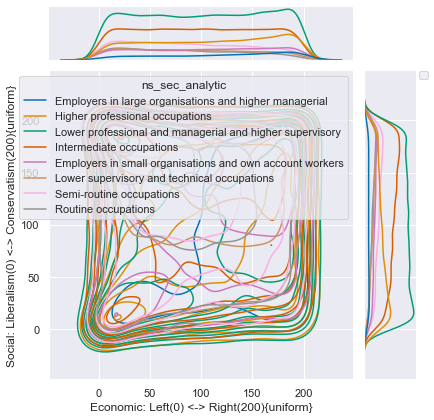

In [52]:
mask = df[['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'ns_sec', 'ns_sec_analytic']].notnull().all(axis=1)

plt.figure(figsize=(16,12))
sns.jointplot(data=df[mask],
                x='Economic: Left(0) <-> Right(200){uniform}',
                y='Social: Liberalism(0) <-> Conservatism(200){uniform}',
                hue='ns_sec_analytic',kind='kde')

#sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


<Figure size 1152x864 with 0 Axes>

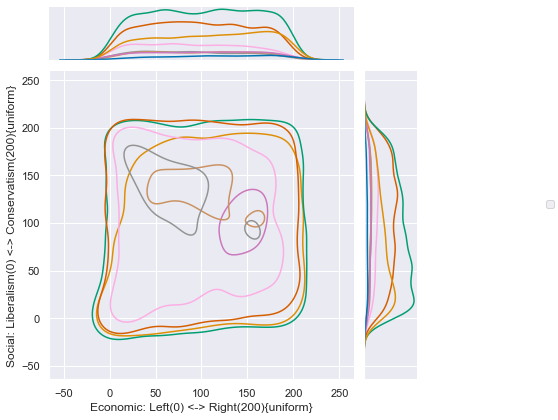

In [53]:
mask = df[['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'ns_sec', 'ns_sec_analytic']].notnull().all(axis=1)
mask = mask & (df["Age_at_W19"]>=30)&(df["Age_at_W19"]<40)

plt.figure(figsize=(16,12))
g = sns.jointplot(data=df[mask],
                x='Economic: Left(0) <-> Right(200){uniform}',
                y='Social: Liberalism(0) <-> Conservatism(200){uniform}',
                hue='ns_sec_analytic',kind='kde',levels=2, thresh=.2,common_norm=True,legend=False)

#sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")
# Put the legend out of the figure
g.fig.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# g.fig.title("30-40 only");

In [54]:
df["ns_sec_analytic"].value_counts()

Lower professional and managerial and higher supervisory    24782
Intermediate occupations                                    16315
Higher professional occupations                             10585
Semi-routine occupations                                     8089
Employers in small organisations and own account workers     5851
Lower supervisory and technical occupations                  5077
Routine occupations                                          4672
Employers in large organisations and higher managerial       2717
Name: ns_sec_analytic, dtype: int64